In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input,GlobalMaxPooling2D,Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt

## SELECT THE DESIRED MODEL ARCHITECTURE ##
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2 as model, preprocess_input
#from tensorflow.keras.applications.resnet50 import ResNet50 as model, preprocess_input
#from tensorflow.keras.applications.vgg16 import VGG16 as model, preprocess_input
#from tensorflow.keras.applications.inception_v3 import InceptionV3 as model, preprocess_input



NUM_CLASSES = 2
CLASSES = ['NEC', 'T1']
TRAIN_PATH = './dataset/train'
TEST_PATH = './dataset/test'

## SELECT THE DESIRED IMAGE RESOLUTION ##
SIZE = 512  # original size (1920x912) -> (640x304)
BATCH_SIZE = 32  # size of the readed batches from generator, must fit on memory
VAL_SPLIT = 0.2  # fraction of the images used for validation

## SELECT THE NAME OF THE MODEL TO SAVE ##
MODEL_NAME = 'model'


2024-01-29 00:46:57.343599: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-29 00:46:57.347417: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-29 00:46:57.380480: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-29 00:46:57.380522: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-29 00:46:57.381842: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

Found 284 images belonging to 2 classes.


Found 70 images belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Images is shape (32, 512, 512, 3)


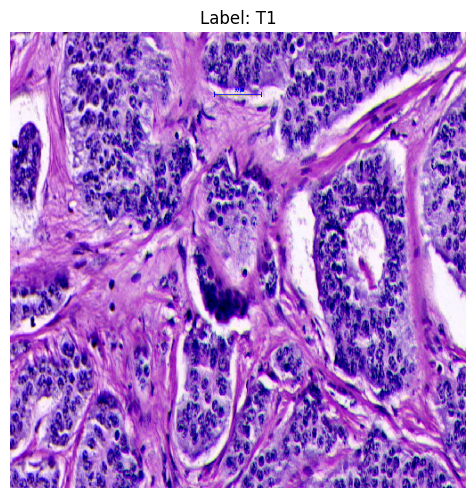

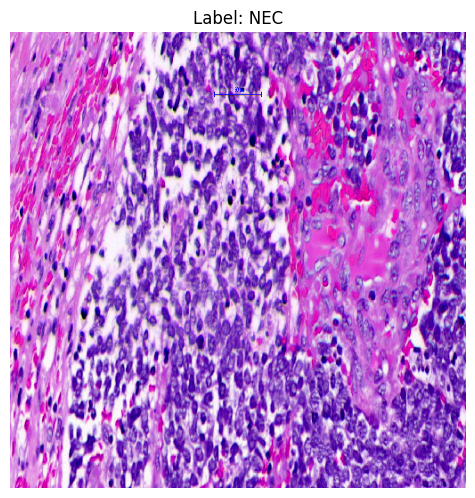

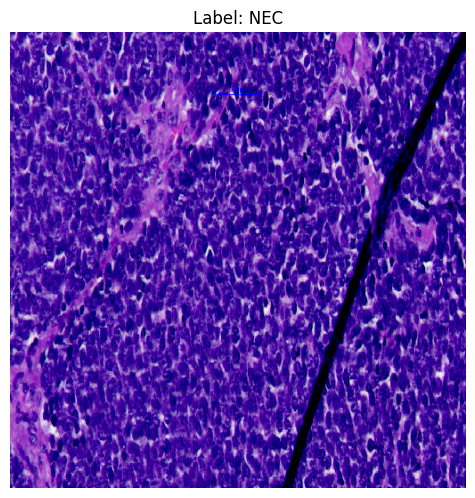

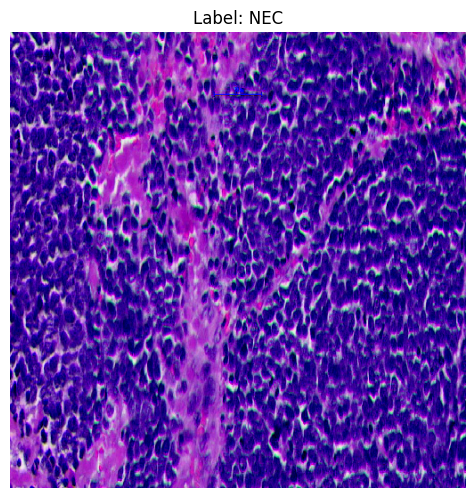

<function matplotlib.pyplot.show(close=None, block=None)>

In [2]:
##########           Image generators           ##########



def preprocess(images):
      # Using the preprocess function of the selected model
      # To ensure the new data is in the same format as the original data the model was trained on
      return preprocess_input(images)


    
seed=123 

train_datagen = ImageDataGenerator(#rescale=1./255,
                                    #rotation_range = 5,
                                    #shear_range=0.2,
                                    #zoom_range=0.2,
                                    #width_shift_range=0.0,
                                    #height_shift_range=0.0,
                                    fill_mode='wrap',
                                    #brightness_range=None,
                                    #horizontal_flip=True,
                                    #vertical_flip=True,
                                    validation_split=0.2,# set validation split
                                    preprocessing_function=preprocess
                                  )

val_datagen = ImageDataGenerator(preprocessing_function=preprocess) #val data can't be augmented

train_generator = train_datagen.flow_from_directory(TRAIN_PATH,
                                                    subset='training',
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='binary',
                                                    seed=seed,    # same shluffle seed in both generators 
                                                    shuffle=True, # to get correct train/val split
                                                    target_size=(SIZE,SIZE)
                                                    )

validation_generator = train_datagen.flow_from_directory(TRAIN_PATH, # same directory as training data
                                                         subset='validation',
                                                         batch_size=BATCH_SIZE,
                                                         class_mode='binary',
                                                         seed=seed,
                                                         shuffle=True,
                                                         target_size=(SIZE,SIZE)
                                                    )

images, labels = train_generator.__next__()
print('Images is shape', images.shape)
    
for i in range(4):
    f = plt.figure(figsize = (20, 20))
    f.add_subplot(1,3,1)
    plt.axis('off')
    plt. title('Label: '+str(CLASSES[int(labels[i])]))
    plt.imshow(images[i])
plt.show(block=True)
plt.show

In [3]:
##########          CNN Construction           ##########

IMG_SHAPE = (SIZE, SIZE, 3)
"""
# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
"""
base_model = model(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

model = tf.keras.Sequential([
                          base_model,
                          tf.keras.layers.GlobalAveragePooling2D(),
                          tf.keras.layers.Dense(1, activation='sigmoid')
                        ])

# Add more metrics if wanted: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#define_the_model_and_metrics
metrics = ['accuracy', 'AUC', 'Precision', 'Recall', 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives']

model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=metrics)

2024-01-29 00:47:00.269671: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: julen-PC
2024-01-29 00:47:00.269696: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: julen-PC
2024-01-29 00:47:00.269784: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: NOT_FOUND: was unable to find libcuda.so DSO loaded into this program
2024-01-29 00:47:00.269813: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 535.146.2


In [4]:
##########           Training           ##########

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)


history = model.fit(train_generator,
                    epochs=20,
                    validation_data=validation_generator,
                    callbacks=[early_stop]
                   )

save_path = './trained_models/'+MODEL_NAME+'.h5'
print('Saving model to:', save_path)
model.save(save_path)

Epoch 1/20


/home/julen/.local/lib/python3.10/site-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


9/9 [==============================] - 20s 2s/step - loss: 1.1521 - accuracy: 0.2218 - auc: 0.2733 - precision: 0.2045 - recall: 0.8308 - true_positives: 54.0000 - true_negatives: 9.0000 - false_positives: 210.0000 - false_negatives: 11.0000 - val_loss: 0.7911 - val_accuracy: 0.3714 - val_auc: 0.5214 - val_precision: 0.2407 - val_recall: 0.8125 - val_true_positives: 13.0000 - val_true_negatives: 13.0000 - val_false_positives: 41.0000 - val_false_negatives: 3.0000
Epoch 2/20
9/9 [==============================] - 16s 2s/step - loss: 0.9098 - accuracy: 0.3239 - auc: 0.3401 - precision: 0.1777 - recall: 0.5385 - true_positives: 35.0000 - true_negatives: 57.0000 - false_positives: 162.0000 - false_negatives: 30.0000 - val_loss: 0.6621 - val_accuracy: 0.6286 - val_auc: 0.6794 - val_precision: 0.3077 - val_recall: 0.5000 - val_true_positives: 8.0000 - val_true_negatives: 36.0000 - val_false_positives: 18.0000 - val_false_negatives: 8.0000
Epoch 3/20
9/9 [==============================] - 17s

2024-01-29 00:49:00.097123: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 100663424 bytes after encountering the first element of size 100663424 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


9/9 [==============================] - 17s 2s/step - loss: 0.4472 - accuracy: 0.8063 - auc: 0.9129 - precision: 1.0000 - recall: 0.1538 - true_positives: 10.0000 - true_negatives: 219.0000 - false_positives: 0.0000e+00 - false_negatives: 55.0000 - val_loss: 0.3840 - val_accuracy: 0.8143 - val_auc: 1.0000 - val_precision: 1.0000 - val_recall: 0.1875 - val_true_positives: 3.0000 - val_true_negatives: 54.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 13.0000
Epoch 8/20
9/9 [==============================] - ETA: 0s - loss: 0.4027 - accuracy: 0.8063 - auc: 0.9744 - precision: 1.0000 - recall: 0.1538 - true_positives: 10.0000 - true_negatives: 219.0000 - false_positives: 0.0000e+00 - false_negatives: 55.0000

2024-01-29 00:49:18.755228: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 100663424 bytes after encountering the first element of size 100663424 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


9/9 [==============================] - 21s 2s/step - loss: 0.4027 - accuracy: 0.8063 - auc: 0.9744 - precision: 1.0000 - recall: 0.1538 - true_positives: 10.0000 - true_negatives: 219.0000 - false_positives: 0.0000e+00 - false_negatives: 55.0000 - val_loss: 0.3577 - val_accuracy: 0.8143 - val_auc: 1.0000 - val_precision: 1.0000 - val_recall: 0.1875 - val_true_positives: 3.0000 - val_true_negatives: 54.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 13.0000
Saving model to: ./trained_models/model.h5


/home/julen/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


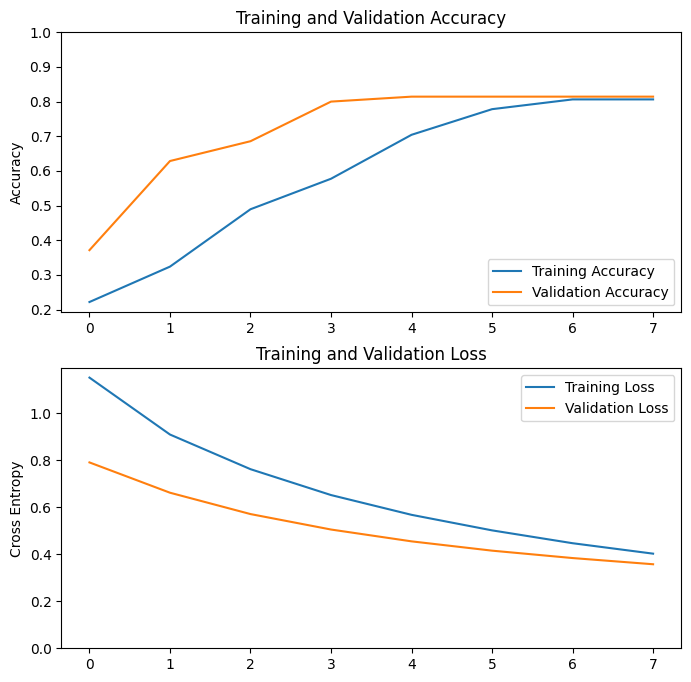

Maximum validation accuracy reached:  0.8142856955528259
Maximum validation accuracy reached at epoch:  5


In [5]:
##########           Model evaluation           ##########

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

max_iou = max(val_acc)
print ("Maximum validation accuracy reached: ", max_iou)
max_index = val_acc.index(max_iou)
print("Maximum validation accuracy reached at epoch: ",max_index+1)

In [11]:
##########           Model test           ##########
from keras.models import load_model

path = './trained_models/'+MODEL_NAME+'.h5'
#model = load_model(path, compile=True)
    

test_datagen = ImageDataGenerator(preprocessing_function=preprocess)

test_generator = test_datagen.flow_from_directory(TEST_PATH,
                                            batch_size=BATCH_SIZE,
                                            class_mode='binary',
                                            shuffle=True,
                                            target_size=(SIZE,SIZE)
                                        )


# Evaluate on Validation data
scores = model.evaluate(validation_generator)


for name, value in zip(model.metrics_names, scores):
  print(name, ': ', value)


Found 88 images belonging to 2 classes.


3/3 [==============================] - 6s 1s/step - loss: 0.4551 - accuracy: 0.8143 - auc: 0.9196 - precision: 1.0000 - recall: 0.1875 - true_positives: 3.0000 - true_negatives: 54.0000 - false_positives: 0.0000e+00 - false_negatives: 13.0000
loss :  0.45511430501937866
accuracy :  0.8142856955528259
auc :  0.9195601940155029
precision :  1.0
recall :  0.1875
true_positives :  3.0
true_negatives :  54.0
false_positives :  0.0
false_negatives :  13.0
